# Mechanisms

In [1]:
from __future__ import print_function, division, absolute_import

import sys

import qminospy
from qminospy.me2 import ME_NLP

# python imports
from copy import copy
import re
from os.path import join, dirname, abspath
import sys
from collections import defaultdict
import pickle

# third party imports
import pandas as pd
import cobra
from tqdm import tqdm
import numpy as np
import scipy

# COBRAme
import cobrame
from cobrame.util import building, mu, me_model_interface
from cobrame.io.json import save_json_me_model, save_reduced_json_me_model

# ECOLIme
import bacillusme
from bacillusme import (transcription, translation, flat_files, generics, formulas, compartments)
from bacillusme.util.helper_functions import *

import copy
%load_ext autoreload
%autoreload 2
ecoli_files = dirname(abspath(bacillusme.__file__))
plt.rcParams['svg.fonttype'] = 'none'
pd.set_option('display.max_colwidth', None)

/home/jt/work/cobrapy-0.5.11/cobra/io/sbml3.py:24: UserWarning: Install lxml for faster SBML I/O
  warn("Install lxml for faster SBML I/O")
/home/jt/work/cobrapy-0.5.11/cobra/io/__init__.py:12: UserWarning: cobra.io.sbml requires libsbml
  warn("cobra.io.sbml requires libsbml")


/home/jt/work/cobrapy-0.5.11/cobra/__init__.py
/home/jt/work/cobrame/cobrame/__init__.py
/home/jt/work/sporeme/bacillusme/__init__.py


In [2]:
with open("./sporeme_solution_v4_proteomics_spoAQ.pickle", "rb") as outfile:
    sporeme = pickle.load(outfile)

In [3]:
def add_transport_to_model(model,mets):
    for met in mets:
        rxn = cobrame.core.reaction.MetabolicReaction('{}_transport'.format(met))
        model.add_reactions([rxn])
        rxn.add_metabolites({
            '{}_c'.format(met):-1,
            '{}_s'.format(met):1
        })
        rxn.bounds = (-1000,1000)
        print(rxn.reaction)

In [4]:
add_transport_to_model(sporeme,['atp'])
solve_me_model(sporeme,
                   max_mu = 0.1,
                   min_mu = .01,
                   using_soplex=False,
                   precision = 1e-6,
                   growth_key = 'sigma',
                   verbosity=2)

atp_c <=> atp_s
Finished compiling expressions in 57.306999 seconds
Finished substituting S,lb,ub in 2.155164 seconds
Finished makeME_LP in 0.287726 seconds
Getting MINOS parameters from ME_NLP...
Finished substituting S,lb,ub in 2.210220 seconds
Finished makeME_LP in 0.282664 seconds
Getting MINOS parameters from ME_NLP...
Finished substituting S,lb,ub in 2.260612 seconds
Finished makeME_LP in 0.277091 seconds
Getting MINOS parameters from ME_NLP...
Finished substituting S,lb,ub in 2.145804 seconds
Finished makeME_LP in 0.280755 seconds
Getting MINOS parameters from ME_NLP...
Finished substituting S,lb,ub in 2.182991 seconds
Finished makeME_LP in 0.277992 seconds
Getting MINOS parameters from ME_NLP...
Finished substituting S,lb,ub in 2.177761 seconds
Finished makeME_LP in 0.280942 seconds
Getting MINOS parameters from ME_NLP...
Finished substituting S,lb,ub in 2.160222 seconds
Finished makeME_LP in 0.287404 seconds
Getting MINOS parameters from ME_NLP...
Finished substituting S,lb,ub

## ATP mechanisms

In [10]:
df = flux_based_reactions(sporeme,'atp_s',only_types=['MetabolicReaction'],growth_symbol = 'sigma')

In [13]:
sporeme.solution.x_dict["biomass_dilution_s"]

0.0328521728515625

In [22]:
prod_df = df[df['met_flux']>1e-16]['met_flux']
prod_df.div(prod_df.sum())

atp_transport                                 0.499796
ADK1_REV_BSU01370-MONOMER_mod_mg2_s           0.496053
PYK_FWD_BSU29180-MONOMER_mod_mn2_mod_k_s    0.00415151
Name: met_flux, dtype: object

In [15]:
for r in prod_df.div(prod_df.sum()).index:
    r = sporeme.reactions.get_by_id(r)
    print(r.id)
    print(r.reaction)
    print()

atp_transport
atp_c <=> atp_s

ADK1_REV_BSU01370-MONOMER_mod_mg2_s
2.0 adp_s --> -4.27350427350427e-6*sigma BSU01370-MONOMER_mod_mg2_s + amp_s + atp_s

PYK_FWD_BSU29180-MONOMER_mod_mn2_mod_k_s
adp_s + h_s + pep_s --> -7.24275931761575e-7*sigma BSU29180-MONOMER_mod_mn2_mod_k_s + atp_s + pyr_s

FACOAL161_ISO_REV_BSU10270-MONOMER_s
amp_s + fa5coa_s + ppi_s --> -4.27350427350427e-6*sigma BSU10270-MONOMER_s + atp_s + coa_s + fa5_s

translation_BSU28450_s
10fthf_s + 20 ala__L_s + 10 arg__L_s + 9 asn__L_s + 2 asp__L_s + 2.0 generic_tRNA_AAA_lys__L_s + 5.0 generic_tRNA_AAC_asn__L_s + 4.0 generic_tRNA_AAU_asn__L_s + 3.0 generic_tRNA_ACA_thr__L_s + 3.0 generic_tRNA_ACC_thr__L_s + 3.0 generic_tRNA_ACG_thr__L_s + generic_tRNA_ACU_thr__L_s + 4.0 generic_tRNA_AGA_arg__L_s + 5.0 generic_tRNA_AGC_ser__L_s + 2.0 generic_tRNA_AGG_arg__L_s + 2.0 generic_tRNA_AUA_ile__L_s + 5.0 generic_tRNA_AUC_ile__L_s + 6.0 generic_tRNA_AUG_met__L_s + 13.0 generic_tRNA_AUU_ile__L_s + 3.0 generic_tRNA_CAA_gln__L_s + 2.0 

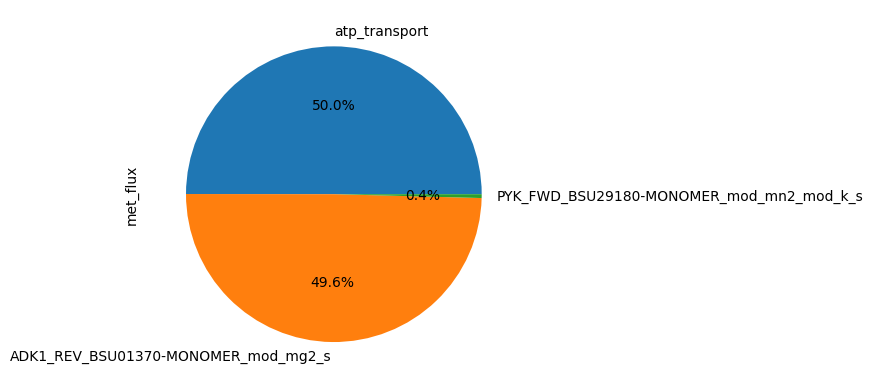

In [29]:
prod_df.plot.pie(autopct = '%1.1f%%')
plt.savefig('figures/ATP_synthesis_spoAQ_with_ATP_transport.svg',format='SVG')

## GFP comparison

In [30]:
plt.rcParams['svg.fonttype'] = 'none'

In [34]:
locus_to_name = pd.read_csv('./gene_name_dictionary.csv',index_col=0)['name'].to_dict()
name_to_locus = pd.read_csv('./gene_name_dictionary.csv',index_col=1)['locus_id'].to_dict()

In [35]:
confirmed_depletions = ['pckA','purL','ilvB','ilvE','citZ','acsA','etfA','acoC','sigF','yxbC','lutC',
                  'argJ','hpf']

In [36]:
l = ['scoB','argJ','citZ','pckA','ilvB','metE','lutC','argD','argB','pyrK','pdhD','gmk','cmk','eno','pyk','gapA']

In [37]:
set(l) & set(confirmed_depletions)

{'argJ', 'citZ', 'ilvB', 'lutC', 'pckA'}

In [38]:
d = {}
for g in l:
    locus = name_to_locus[g]
    if not sporeme.metabolites.query(locus):
        print(g, ' not in model')
        continue
    mc = sporeme.solution.x_dict['translation_{}'.format(locus)]
    fs = sporeme.solution.x_dict['translation_{}_s'.format(locus)]
    d[g] = {'mc':mc,'fs':fs}

lutC  not in model


In [39]:
df = pd.DataFrame.from_dict(d).T
df[df<1e-16] = 0
df = df.div(df.sum(axis=1),axis=0).fillna(0) * 100
df

,mc,fs
scoB,0.000000,0.000000
argJ,100.000000,0.000000
citZ,100.000000,0.000000
pckA,100.000000,0.000000
ilvB,100.000000,0.000000
metE,100.000000,0.000000
argD,100.000000,0.000000
argB,100.000000,0.000000
pyrK,100.000000,0.000000
pdhD,97.791922,2.208078


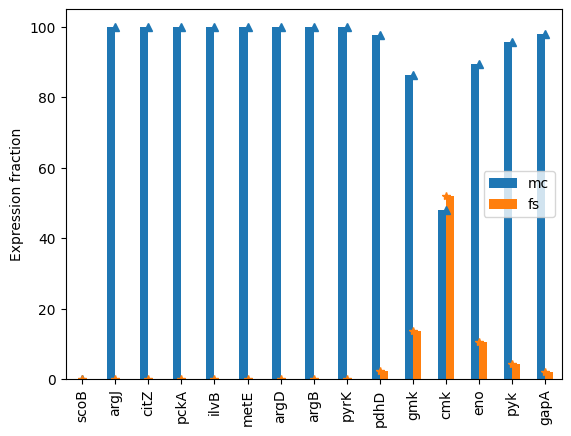

In [40]:
ax = df.plot.bar(stacked=False)
# ax.invert_yaxis()
plt.plot(df.index,df['mc'],'^')
plt.plot(df.index,df['fs'],'*')
plt.ylabel('Expression fraction')
plt.savefig('figures/STRP_comparison.svg',format='SVG')

## NADH mechanisms

In [41]:
df = flux_based_reactions(sporeme,'nadh_s',only_types=['MetabolicReaction'],growth_symbol = 'sigma')

In [46]:
prod_df = df[df['met_flux']>1e-16]['met_flux']
prod_df.div(prod_df.sum())

PDH_FWD_CPLX000-61_s            0.898501
OIVD3_FWD_CPLX000-60_s         0.0501029
OIVD1r_FWD_CPLX000-58_s         0.026525
MDH_FWD_BSU29120-MONOMER_s      0.018977
OIVD2_FWD_CPLX000-59_s        0.00589445
Name: met_flux, dtype: object

In [43]:
for r in prod_df.div(prod_df.sum()).index:
    r = sporeme.reactions.get_by_id(r)
    print(r.id)
    print(r.reaction)
    print()

PDH_FWD_CPLX000-61_s
coa_s + nad_s + pyr_s --> -4.27350427350427e-6*sigma CPLX000-61_s + accoa_s + co2_s + nadh_s

OIVD3_FWD_CPLX000-60_s
3mop_s + coa_s + nad_s --> 2mbcoa_s + -4.27350427350427e-6*sigma CPLX000-60_s + co2_s + nadh_s

OIVD1r_FWD_CPLX000-58_s
4mop_s + coa_s + nad_s --> -4.27350427350427e-6*sigma CPLX000-58_s + co2_s + ivcoa_s + nadh_s

MDH_FWD_BSU29120-MONOMER_s
mal__L_s + nad_s --> -1.93076423348459e-6*sigma BSU29120-MONOMER_s + h_s + nadh_s + oaa_s

OIVD2_FWD_CPLX000-59_s
3mob_s + coa_s + nad_s --> -4.27350427350427e-6*sigma CPLX000-59_s + co2_s + ibcoa_s + nadh_s

UDPGD_REV_BSU35580-MONOMER_s
3.0 h_s + 2.0 nadh_s + udpglcur_s --> -7.6432684724297e-5*sigma BSU35580-MONOMER_s + h2o_s + 2.0 nad_s + udpg_s



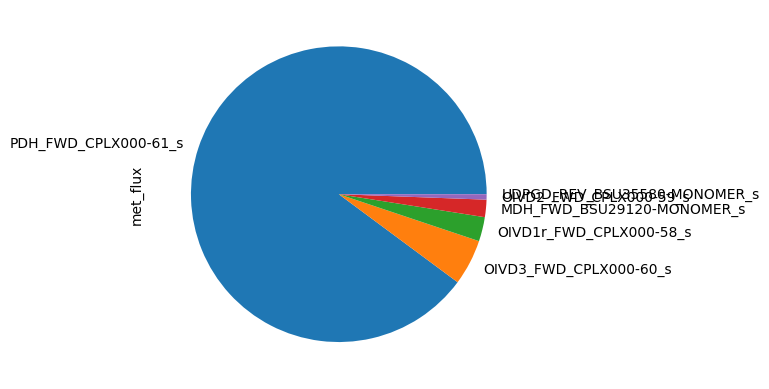

In [45]:
prod_df.plot.pie()
plt.savefig('figures/NADH_synthesis_spoAQ_with_ATP_transport.svg',format='SVG')